<a href="https://colab.research.google.com/github/SanazKaz/Medical_Imaging/blob/main/Imaging_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaging Project

Using the BACH dataset we will develop a machine learning model that distinguishes between normal breast tissue and carcinoma. Our dataset contains the following:

* Normal: 100
* Benign: 100
* in situ carcinoma: 100
* Invasive carcinoma: 100

It can be found and downloaded here:

' Classification of Breast Cancer Histology Images (BACH) https://iciar2018-challenge.grandchallenge.org/Dataset/ '


much of this notebook is similar to https://teddykoker.com/2019/08/histopathologic-cancer-detection-with-transfer-learning/

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import torch
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True

In [ ]:
import random
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class HistologyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images (contains 'normal' and 'carcinoma' subdirectories).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load normal images
        normal_dir = os.path.join(root_dir, 'Normal')
        for img_name in os.listdir(normal_dir):
            if img_name.endswith('.tif'):
                self.image_paths.append(os.path.join(normal_dir, img_name))
                self.labels.append(0)  # 0 for normal

        benign_dir = os.path.join(root_dir, 'Benign')
        for img_name in os.listdir(benign_dir):
            if img_name.endswith('.tif'):
                self.image_paths.append(os.path.join(benign_dir, img_name))
                self.labels.append(1)  # 1 for benign

        insitu_carcinoma_dir = os.path.join(root_dir, 'InSitu')
        for img_name in os.listdir(insitu_carcinoma_dir):
            if img_name.endswith('.tif'):
                self.image_paths.append(os.path.join(insitu_carcinoma_dir, img_name))
                self.labels.append(2)  # '2' for in situ carcinoma

        invasive_carcinoma_dir = os.path.join(root_dir, 'Invasive')
        for img_name in os.listdir(invasive_carcinoma_dir):
            if img_name.endswith('.tif'):
                self.image_paths.append(os.path.join(invasive_carcinoma_dir, img_name))
                self.labels.append(3)  # '3' for invasive carcinoma

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label




In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to fit the model input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for pre-trained models
])

# Initialize your dataset
dataset = HistologyDataset('/content/drive/MyDrive/Mini_project', transform=transform)

In [ ]:
import torch
from torchvision import utils

def show_images(images, labels, n_images=5):
    fig, axs = plt.subplots(1, n_images, figsize=(15, 5))
    for i, ax in enumerate(axs.flat):
        if i >= len(images):  # Check if the index exceeds the number of images
            break
        if images[i].shape[0] == 3:  # If the image has 3 channels
            ax.imshow(images[i].permute(1, 2, 0))  # Rearrange the dimensions

        # Determine the label and set the title accordingly
        if labels[i] == 0:
            label_text = "Normal"
        elif labels[i] == 1:
            label_text = "Benign"
        elif labels[i] == 2:
            label_text = "In Situ Carcinoma"
        elif labels[i] == 3:
            label_text = "Invasive Carcinoma"
        else:
            label_text = "Unknown"

        ax.set_title(f'Label: {label_text} ({labels[i]})')
        ax.axis('off')
    plt.show()

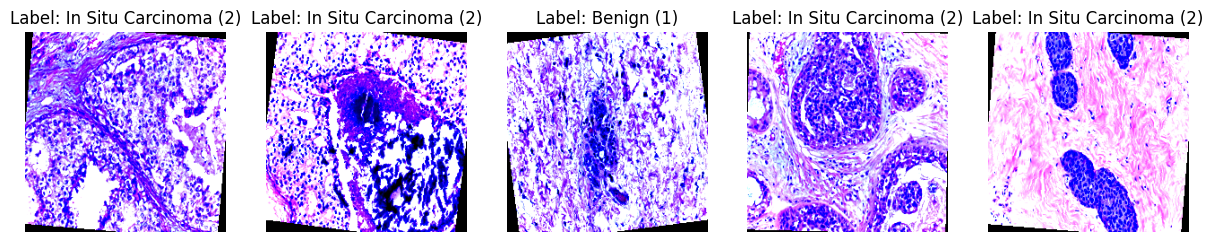

In [ ]:
from torch.utils.data import DataLoader

# Assuming you have already initialized your dataset as 'dataset'
data_loader = DataLoader(dataset, batch_size=5, shuffle=True)

# Fetch one batch of images
images, labels = next(iter(data_loader))

# Show the images
show_images(images, labels, n_images=5)


In [ ]:
import numpy as np


#  same as you did in classification (here we are doing )
from torch.utils.data.sampler import SubsetRandomSampler

num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)  # Shuffle to ensure random distribution

split_test = int(np.floor(0.1 * num_train))
split_val = int(np.floor(0.2 * (num_train - split_test)))
split_train = num_train - split_val - split_test  # The rest goes to training


# Update the train_idx to reduce the size by the test set portion
# New approach: Deduct the test set based on its percentage first
test_idx = indices[:split_test]  # Indices for the test set
valid_idx = indices[split_test:(split_test + split_val)]  # No change here, validation set remains the same
train_idx = indices[(split_val + split_test):]
# Now allocate the last portion of the dataset for testing

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(len(train_sampler))
print(len(valid_sampler))
print(len(test_sampler))

# Now create data loaders (same as before)
# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 16 # create batch-based on how much memory you have and your data size

traindataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0, drop_last=True)
valdataloader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler,
            num_workers=0,)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=0,)



288
72
40


In [ ]:
print(len(valid_idx))

72


In [ ]:
print('Number of batches training samples:', len(train_sampler))
print('Number of batches validation samples:', len(valid_sampler))
print('Number of batches testing samples:', len(test_sampler))

Number of batches training samples: 18
Number of batches validation samples: 5
Number of batches testing samples: 3


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

resnet = models.resnet18(pretrained=True)
in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=4),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [ ]:
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import torch


def train(train_loader, model, criterion, optimizer):
    total_loss = 0.0
    size = len(train_loader.dataset)
    num_batches = size // train_loader.batch_size
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        print(f"Training: {i}/{num_batches}", end="\r")

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()  # backprogagation
        optimizer.step() # update model parameters
        torch.cuda.empty_cache()

    return total_loss / size # average loss

def validate(valid_loader, model, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_loss = 0.0
    all_preds =[]
    all_labels = []
    size = len(valid_loader.dataset)  # Total number of samples
    #print("datatset length: ", size)
    with torch.no_grad():  # Disabling gradient calculation
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

            total_correct += (preds == labels).sum()  # Summing up correct predictions
            total_loss += loss.item() * images.size(0)  # Accumulating loss

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    avg_loss = total_loss / len(valid_sampler)  # Average loss
    accuracy_percentage = (total_correct / len(valid_sampler)) * 100  # Accuracy calculation

    # Return or print your results
    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy_percentage:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    return avg_loss, accuracy_percentage.item(), precision, recall, f1  # Converting accuracy to Python number

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

def fit(model, num_epochs, train_loader, valid_loader, optimizer, criterion):
  print("epoch\ttrain loss\tvalid loss \taccuracy")
  for epoch in range(num_epochs):
        train_loss = train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc, valid_precision, valid_recall, valid_f1  = validate(valid_loader, model, criterion)
        print(f"{epoch}\t{train_loss:.5f}\t\t{valid_loss:.5f}\t\t{valid_acc:.3f}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum= 0.7)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [ ]:
model.to(device)  # Move model to the appropriate device
num_epochs = 15  # Set the number of epochs

# Start the training and validation process
fit(model, num_epochs, traindataloader, valdataloader, optimizer, criterion)



epoch	train loss	valid loss 	accuracy
Validation Loss: 0.7441, Accuracy: 70.83%
Precision: 0.6995, Recall: 0.7083, F1 Score: 0.6989
0	0.51340		0.74410		70.833
Validation Loss: 0.6877, Accuracy: 76.39%
Precision: 0.7628, Recall: 0.7639, F1 Score: 0.7631
1	0.50689		0.68772		76.389
Validation Loss: 0.7107, Accuracy: 76.39%
Precision: 0.7653, Recall: 0.7639, F1 Score: 0.7571
2	0.53893		0.71065		76.389
Validation Loss: 0.7195, Accuracy: 68.06%
Precision: 0.6707, Recall: 0.6806, F1 Score: 0.6704
3	0.51585		0.71947		68.056
Validation Loss: 0.7083, Accuracy: 72.22%
Precision: 0.7368, Recall: 0.7222, F1 Score: 0.7076
4	0.52278		0.70832		72.222
Validation Loss: 0.6898, Accuracy: 76.39%
Precision: 0.7657, Recall: 0.7639, F1 Score: 0.7581
5	0.55577		0.68980		76.389
Validation Loss: 0.7095, Accuracy: 69.44%
Precision: 0.6893, Recall: 0.6944, F1 Score: 0.6821
6	0.49898		0.70946		69.444
Validation Loss: 0.7289, Accuracy: 68.06%
Precision: 0.6871, Recall: 0.6806, F1 Score: 0.6737
7	0.54480		0.72890		6

In [ ]:
torch.save(model.state_dict(), 'model_state_dict.pth')


ToDo
Precision - positive predictive value
Recall - sensitivity  TPR
Accuracy
F1 score = 2(precision *recall / precision/ recall

confusion matrix
roc curve
auc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

resnet = models.resnet18(pretrained=True)
in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=4),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.load_state_dict(torch.load('model_state_dict.pth'))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


<All keys matched successfully>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns  # For a nicer confusion matrix visualization


model.eval()
correct = 0
total = 0
with torch.no_grad():  # Disables gradient calculation to save memory and computations
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
print(correct)

32


In [ ]:
print(total)

40


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns  # For a nicer confusion matrix visualization

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


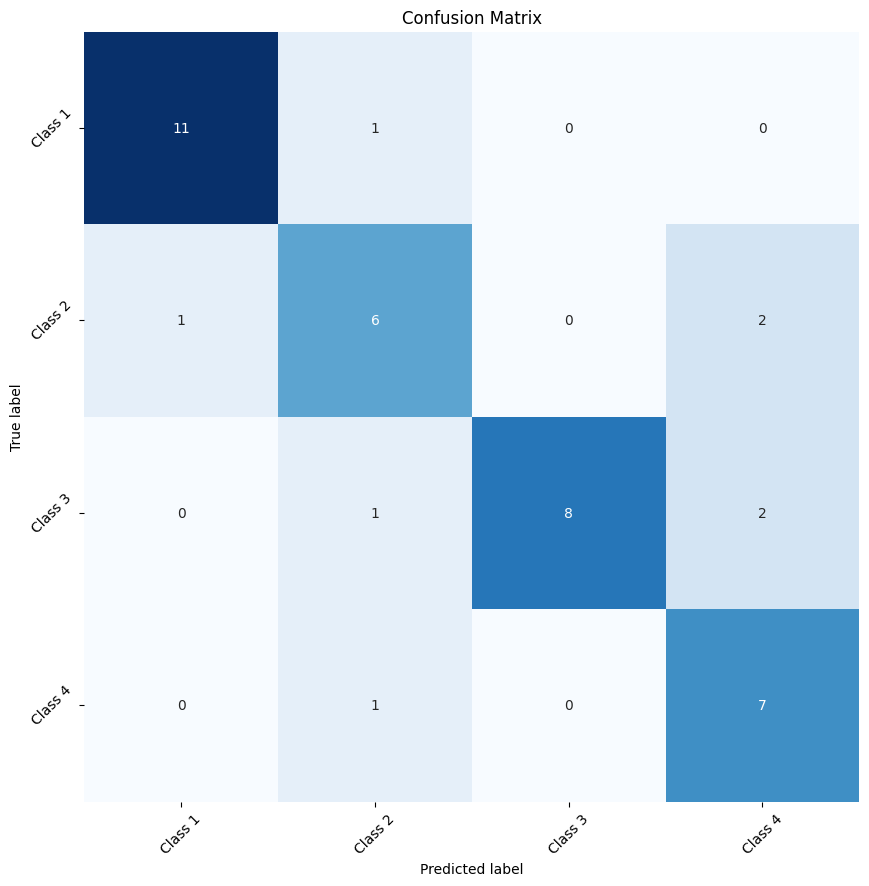

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted label", ylabel="True label", xticklabels=classes, yticklabels=classes)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you know the class names
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']  # Adjust as per your classes
plot_confusion_matrix(y_true, y_pred, class_names)


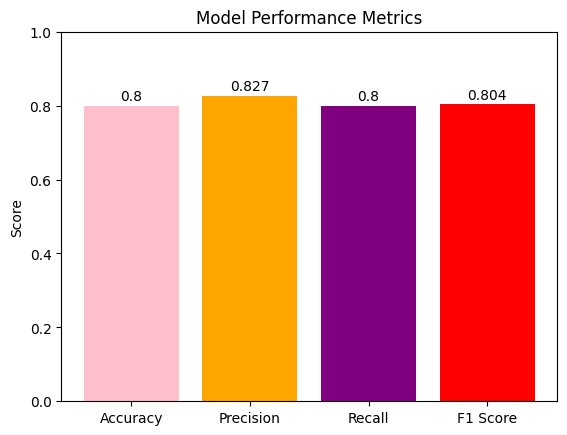

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

def plot_metrics(accuracy, precision, recall, f1):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    fig, ax = plt.subplots()
    bars = plt.bar(metrics, values, color=['pink', 'orange', 'purple', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Model Performance Metrics')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + .005, round(yval, 3), ha='center', va='bottom')

    plt.show()

plot_metrics(accuracy, precision, recall, f1)


In [ ]:
model.eval()

y_true = []  # To store true labels
y_score = []  # To store predicted probabilities

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_score.extend(probabilities.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

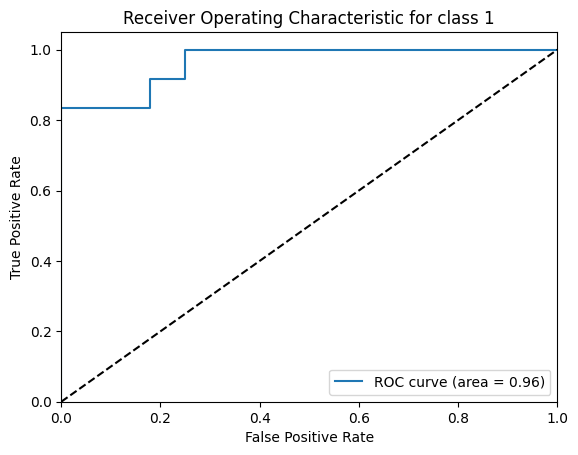

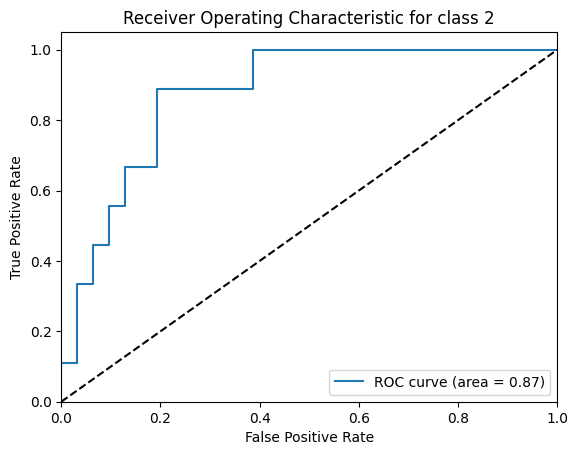

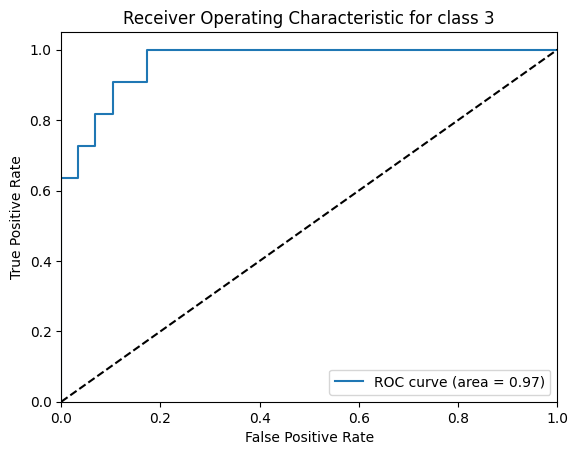

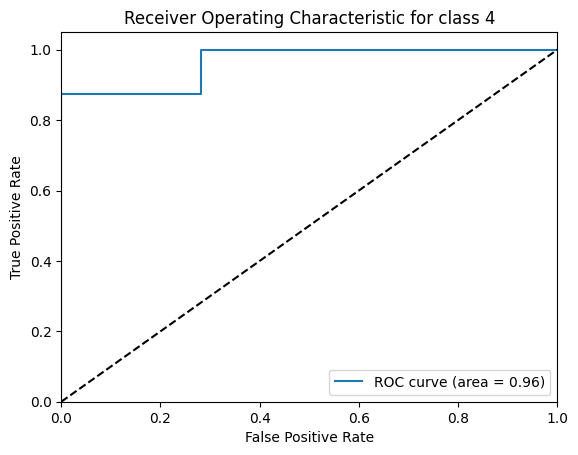

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Number of classes
n_classes = y_score.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true == i, y_score[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i+1))
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
model.eval()  # Set the model to evaluation mode
images, labels = next(iter(test_dataloader))  # Get one batch from the dataloader
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Filter out correctly classified images
misclassified_indices = preds != labels
misclassified_images = images[misclassified_indices]
misclassified_labels = labels[misclassified_indices]
misclassified_preds = preds[misclassified_indices]

# Move to CPU for visualization
misclassified_images = misclassified_images.cpu()
misclassified_labels = misclassified_labels.cpu()
misclassified_preds = misclassified_preds.cpu()


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
def plot_misclassified_images(images, true_labels, pred_labels, classes):
    n_images = len(images)  # Number of misclassified images
    if n_images > 10:  # Limit the number of images to display
        n_images = 10
    fig = plt.figure(figsize=(60, 30))
    for idx in range(n_images):
        ax = fig.add_subplot(2, n_images//2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(f"True: {classes[true_labels[idx]]}\nPred: {classes[pred_labels[idx]]}", color="red", fontsize = 14)

classes = ['normal', 'benign', 'inSitu', 'Invasive']  # Update class names accordingly
plot_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds, classes)


NameError: name 'misclassified_images' is not defined